# Color Mapping Creation for Miniature-Scale Physical-World Experiment

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# STEP1: Capture a gray-scale pallet

Since the DRP attack uses only grayscale perturbations, we need to know what color the camera perceives grayscale to be. Thus, we prepare a gray-scale pallet containg all 256 (8-bit) grayscale colors and capture it.

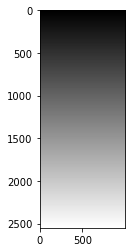

In [2]:
### Gray scale pallet
patch = np.zeros((255 * 10, 1000), dtype=np.uint8)
for i in range(0, 255):
    patch[i*10: (i+1) * 10] = i
plt.imshow(patch, cmap='gray')

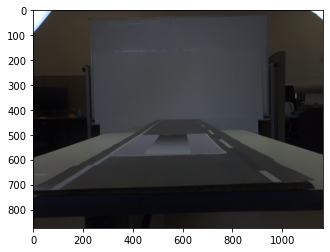

In [3]:
### Capture it in a camera (OpenPilot dashcam)
img = cv2.cvtColor(cv2.imread('data/img_physical_world_pallet.png'), cv2.COLOR_BGR2RGB)
plt.imshow(img)

# STEP2: Extract color mappings

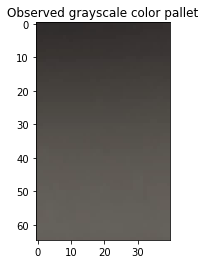

In [4]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
bev = img[510:575, 560:600]
plt.imshow(bev)
plt.title('Observed grayscale color pallet')
plt.imshow(bev)
plt.show()

Text(0.5, 0, 'Source color')

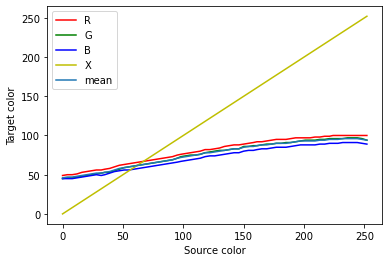

In [5]:
df = pd.DataFrame(bev.mean(axis=1), columns=['R','G','B'])#.plot(style=['r', 'g', 'b'])
df['source'] = np.round((df.index.values / df.shape[0] * 256)).astype(int)
df = df.groupby('source').mean().astype(int)
df['X'] = df.index.values
df['mean'] = np.round(df[['R','G','B']].mean(axis=1)).astype(int)
df.plot(style=['r', 'g', 'b', 'y'])
plt.ylabel('Target color')
plt.xlabel('Source color')

The yellow line is the case that the obserbed colors and the prited pallee colors are the same. As shown, the colors less than 50 are obserbed brighter. The colors over 50 are observed darker. If you change the lighting conditions or the printer, this color mapping will be different.

# STEP3: Complete all 256 grayscale color mappings

In [6]:
from scipy.interpolate import UnivariateSpline
tmp = df[['mean']].reset_index().groupby('mean', as_index=False)['source'].min().rename({'mean': 'target'}, axis=1)#.set_index('source')#.reindex(np.arange(256))

sp = UnivariateSpline(tmp['source'], tmp['target'], k=3)
#map_sim2patch = map_sim2patch.fillna(method='ffill').fillna(method='bfill')

source = np.arange(256)
target = sp(source).astype(np.uint8)
df_sim2patch = pd.DataFrame({
    'source': source,
    'target': target
})

Text(0.5, 0, 'Source color')

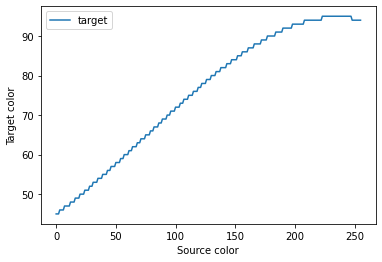

In [7]:
df_sim2patch.set_index('source').plot()
plt.ylabel('Target color')
plt.xlabel('Source color')

# STEP4: Replace colors in patch based on color mapping

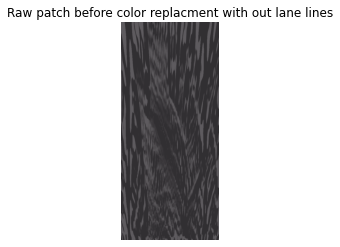

In [8]:
raw_patch = cv2.cvtColor(cv2.imread('data/patch_for_physical_before_color_change.png'), cv2.COLOR_BGR2RGB)

# Since above color mapping is not so accurate, I prepare more accurate color mapping for base color.
base_color = np.array([49, 47, 50])
observed_base_color = np.array([93.69449545, 92.59961091, 89.35799455])

plt.title('Raw patch before color replacment with out lane lines')
plt.imshow(raw_patch)
plt.axis('off')
plt.show()

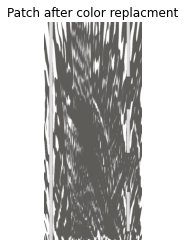

In [10]:
scale = 5
left_lane_pos = 2.5
right_lane_pos = 38
LANE_WIDTH = 1.5

map_sim2patch = df_sim2patch.set_index('target')['source'].to_dict()
    
patch = raw_patch.clip(df_sim2patch['target'].min(), df_sim2patch['target'].max())

for i in range(patch.shape[0]):
    for j in range(patch.shape[1]):
        # base color and darker than base color use the base color mapping since the perturbation is always brighter than base color.
        if np.abs(base_color - patch[i, j]).sum() > 0 and map_sim2patch[patch[i, j].max()] > np.min(observed_base_color):
            patch[i, j] = [map_sim2patch[patch[i, j, 0]]] * 3
        else:
            patch[i, j] = observed_base_color

# Drawing lane lines
patch[:, int(left_lane_pos * scale)*2:int((left_lane_pos + LANE_WIDTH) * scale)*2] = 220

patch[0*scale * 2:25 * scale * 2, right_lane_pos * scale * 2:int((right_lane_pos + LANE_WIDTH) * scale) *2] = 220
patch[40*scale * 2:60 * scale * 2, right_lane_pos * scale * 2:int((right_lane_pos + LANE_WIDTH) * scale) * 2] = 220
patch[78*scale * 2:96 * scale * 2, right_lane_pos * scale * 2:int((right_lane_pos + LANE_WIDTH) * scale) * 2] = 220
            
patch = np.uint8(patch)

plt.title('Patch after color replacment')
plt.imshow(patch)
plt.axis('off')
plt.show()